# COMP551: Project 4

####Group 77:
#####Authors : Ying Sun, Said Khalifef & Boury Mbodj
#####Date : March 16th 2019
#####Subject: The given file contains the implementation of the squeezenet1_0

In [0]:
import pandas as pd
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [0]:
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

In [3]:
%%time
transform = transforms.Compose([transforms.Resize(32,32),
                               transforms.ToTensor(),
                               #transforms.Lambda(lambda x: x.repeat(3,1,1)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False,num_workers=2)

0it [00:00, ?it/s]

100%|█████████▉| 169779200/170498071 [00:26<00:00, 5199265.19it/s]

Files already downloaded and verified
CPU times: user 3.85 s, sys: 1.65 s, total: 5.51 s
Wall time: 30.2 s


In [4]:
#*********************************************************************
%%time
# model part
import torchvision.models as models
# use pretrained model:
model = models.squeezenet1_0(pretrained = True)
#import OrderedDicted to corectly align the network layers


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.torch/models/squeezenet1_0-a815701f.pth

0it [00:00, ?it/s]
1040384it [00:00, 9947130.47it/s]
5017600it [00:00, 27574841.66it/s]

CPU times: user 124 ms, sys: 37.7 ms, total: 162 ms
Wall time: 904 ms


In [5]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [0]:
#import nn to modify features
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs

classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 10, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(1)
)


In [0]:
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)



In [0]:
# For CNN Microarchitecture Design Space Exploration- Squeeze ratio experiments 
#fire paraemters are inplanes, squeeze_planes,expand1x1_planes, expand3x3_planes):
#  Keeping this for referral purposes      
#model.features = nn.Sequential(
                #nn.Conv2d(3, 96, kernel_size=7, stride=2),
                #nn.ReLU(inplace=True),
                #nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                #Fire(96, 16, 64, 64),
                #Fire(128, 16, 64, 64),
                #Fire(128, 32, 128, 128),
                #nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                #Fire(256, 32, 128, 128),
                #Fire(256, 48, 192, 192),
                #Fire(384, 48, 192, 192),
                #Fire(384, 64, 256, 256),
                #nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                #Fire(512, 64, 256, 256),
           # )   
features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 128, 128),
                Fire(256, 32, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 32, 256, 256),
                Fire(512, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
#model.features= features
#replace the model's classifier with this new classifier 
model.classifier = classifier
model.forward = lambda x: model.classifier(model.features(x)).view(x.size(0), 10)



In [9]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0004, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    current_correct_5=0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)#The most likelihood
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)#Top-5 prediction
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        for i in range(100):
            for j in preds_5[i]:
                current_correct_5+=torch.sum(y_train.data[i]==j)
        #print(output,preds,preds_5)
        #check if the training is correct: 
        #print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/100 # Top 1 accuracy
    epoch_acc_5 = current_correct_5.double()/len(loader)/100 #Top 5 accuracy
        
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_correct_5 = 0 #Top 5 accuracy
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
        for i in range(100):
            for j in preds_5[i]:
                valid_correct_5+=torch.sum(y_valid.data[i]==j)
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/100
    epoch_acc_5 = valid_correct_5.double() / len(loader)/100
    
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [14]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
train_acc_5 =[]
valid_losses=[]
valid_acc =[]
valid_acc_5 =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 16 
epoch = 0
import time
start=time.time()
for e in range(epochs):
    start_train = time.time()
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc, epoch_train_acc_5 = train(model,trainloader, criteria, 1)
        #epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        train_acc_5.append(epoch_train_acc_5)
    print("Epoch: {} Train Loss : {:.4f}  Top1 Accuracy: {:.4f}  Top5 Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc,epoch_train_acc_5))
    end_train=time.time()
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc,epoch_val_acc_5 = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
        valid_acc_5.append(epoch_val_acc_5)
    print("Epoch: {} Validation Loss : {:.4f}  Top 1 Validation Accuracy {:.4f} Top5 Validation Accuracy: {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc,epoch_val_acc_5))
    end_valid = time.time()
    print("Training time for Epoch {}: {:.4f}s".format(epoch,end_train-start_train))
    print("Validation time for Epoch {}: {:.4f}s".format(epoch,end_valid-end_train))
end=time.time()
print("Total time for training and validation: {:.4f}s".format(end-start))

1


170500096it [00:40, 5199265.19it/s]                               

Epoch: 1 Train Loss : 230.6294  Top1 Accuracy: 0.1042  Top5 Accuracy: 0.5084
Epoch: 1 Validation Loss : 215.8495  Top 1 Validation Accuracy 0.1403 Top5 Validation Accuracy: 0.5709
Training time for Epoch 1: 38.8671s
Validation time for Epoch 1: 6.3635s
2
Epoch: 2 Train Loss : 196.8501  Top1 Accuracy: 0.2905  Top5 Accuracy: 0.6628
Epoch: 2 Validation Loss : 146.5178  Top 1 Validation Accuracy 0.5025 Top5 Validation Accuracy: 0.9251
Training time for Epoch 2: 38.9635s
Validation time for Epoch 2: 6.4062s
3
Epoch: 3 Train Loss : 136.3770  Top1 Accuracy: 0.5231  Top5 Accuracy: 0.9339
Epoch: 3 Validation Loss : 110.2468  Top 1 Validation Accuracy 0.6176 Top5 Validation Accuracy: 0.9594
Training time for Epoch 3: 38.4777s
Validation time for Epoch 3: 6.5115s
4
Epoch: 4 Train Loss : 116.0506  Top1 Accuracy: 0.6032  Top5 Accuracy: 0.9561
Epoch: 4 Validation Loss : 98.2478  Top 1 Validation Accuracy 0.6593 Top5 Validation Accuracy: 0.9670
Training time for Epoch 4: 39.0323s
Validation time for 

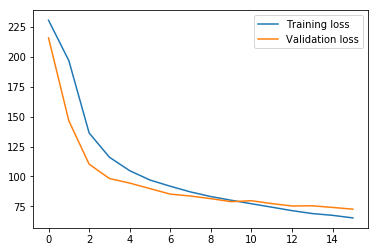

In [15]:
#Plot training and validation losses
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

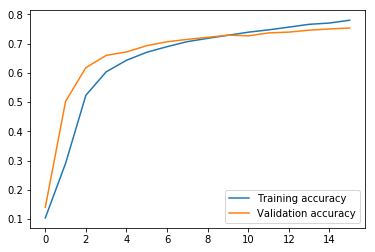

In [16]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [17]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset        loss
  0       1   train  230.629443
  1       2   train  196.850109
  2       3   train  136.376987
  3       4   train  116.050634
  4       5   train  104.781807
  5       6   train   96.978077
  6       7   train   91.781252
  7       8   train   87.018761
  8       9   train   83.161279
  9      10   train   80.080055
  10     11   train   77.152341
  11     12   train   74.281947
  12     13   train   71.385871
  13     14   train   68.933858
  14     15   train   67.442653
  15     16   train   65.293084
  16      1   valid  215.849537
  17      2   valid  146.517804
  18      3   valid  110.246780
  19      4   valid   98.247836
  20      5   valid   94.424896
  21      6   valid   89.787836
  22      7   valid   85.199174
  23      8   valid   83.584329
  24      9   valid   81.410943
  25     10   valid   78.880765
  26     11   valid   79.672998
  27     12   valid   77.284733
  28     13   valid   75.269890
  29     14   valid   75.442024
  30     15   valid   74.049226
  31     16   valid   72.589253,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})